# 필요한 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
from sklearn.metrics import mean_absolute_error
import pickle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,StandardScaler,PowerTransformer,MinMaxScaler
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
import tensorflow as tf
warnings.filterwarnings(action='ignore')

# 데이터로드

In [3]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
midfielder_df = fm_data_df[fm_data_df['포지션']=='미드필더']

# 미드필더 EDA

In [4]:
# 데이터 분석에 필요한 변수만 추출

num_col = [midfielder_df.columns[i] for i,x in enumerate(midfielder_df.dtypes) if x == 'int64' or x == 'float64']
features = list(set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90']))
target = ['평균획득승점/경기']

## 이상치 확인

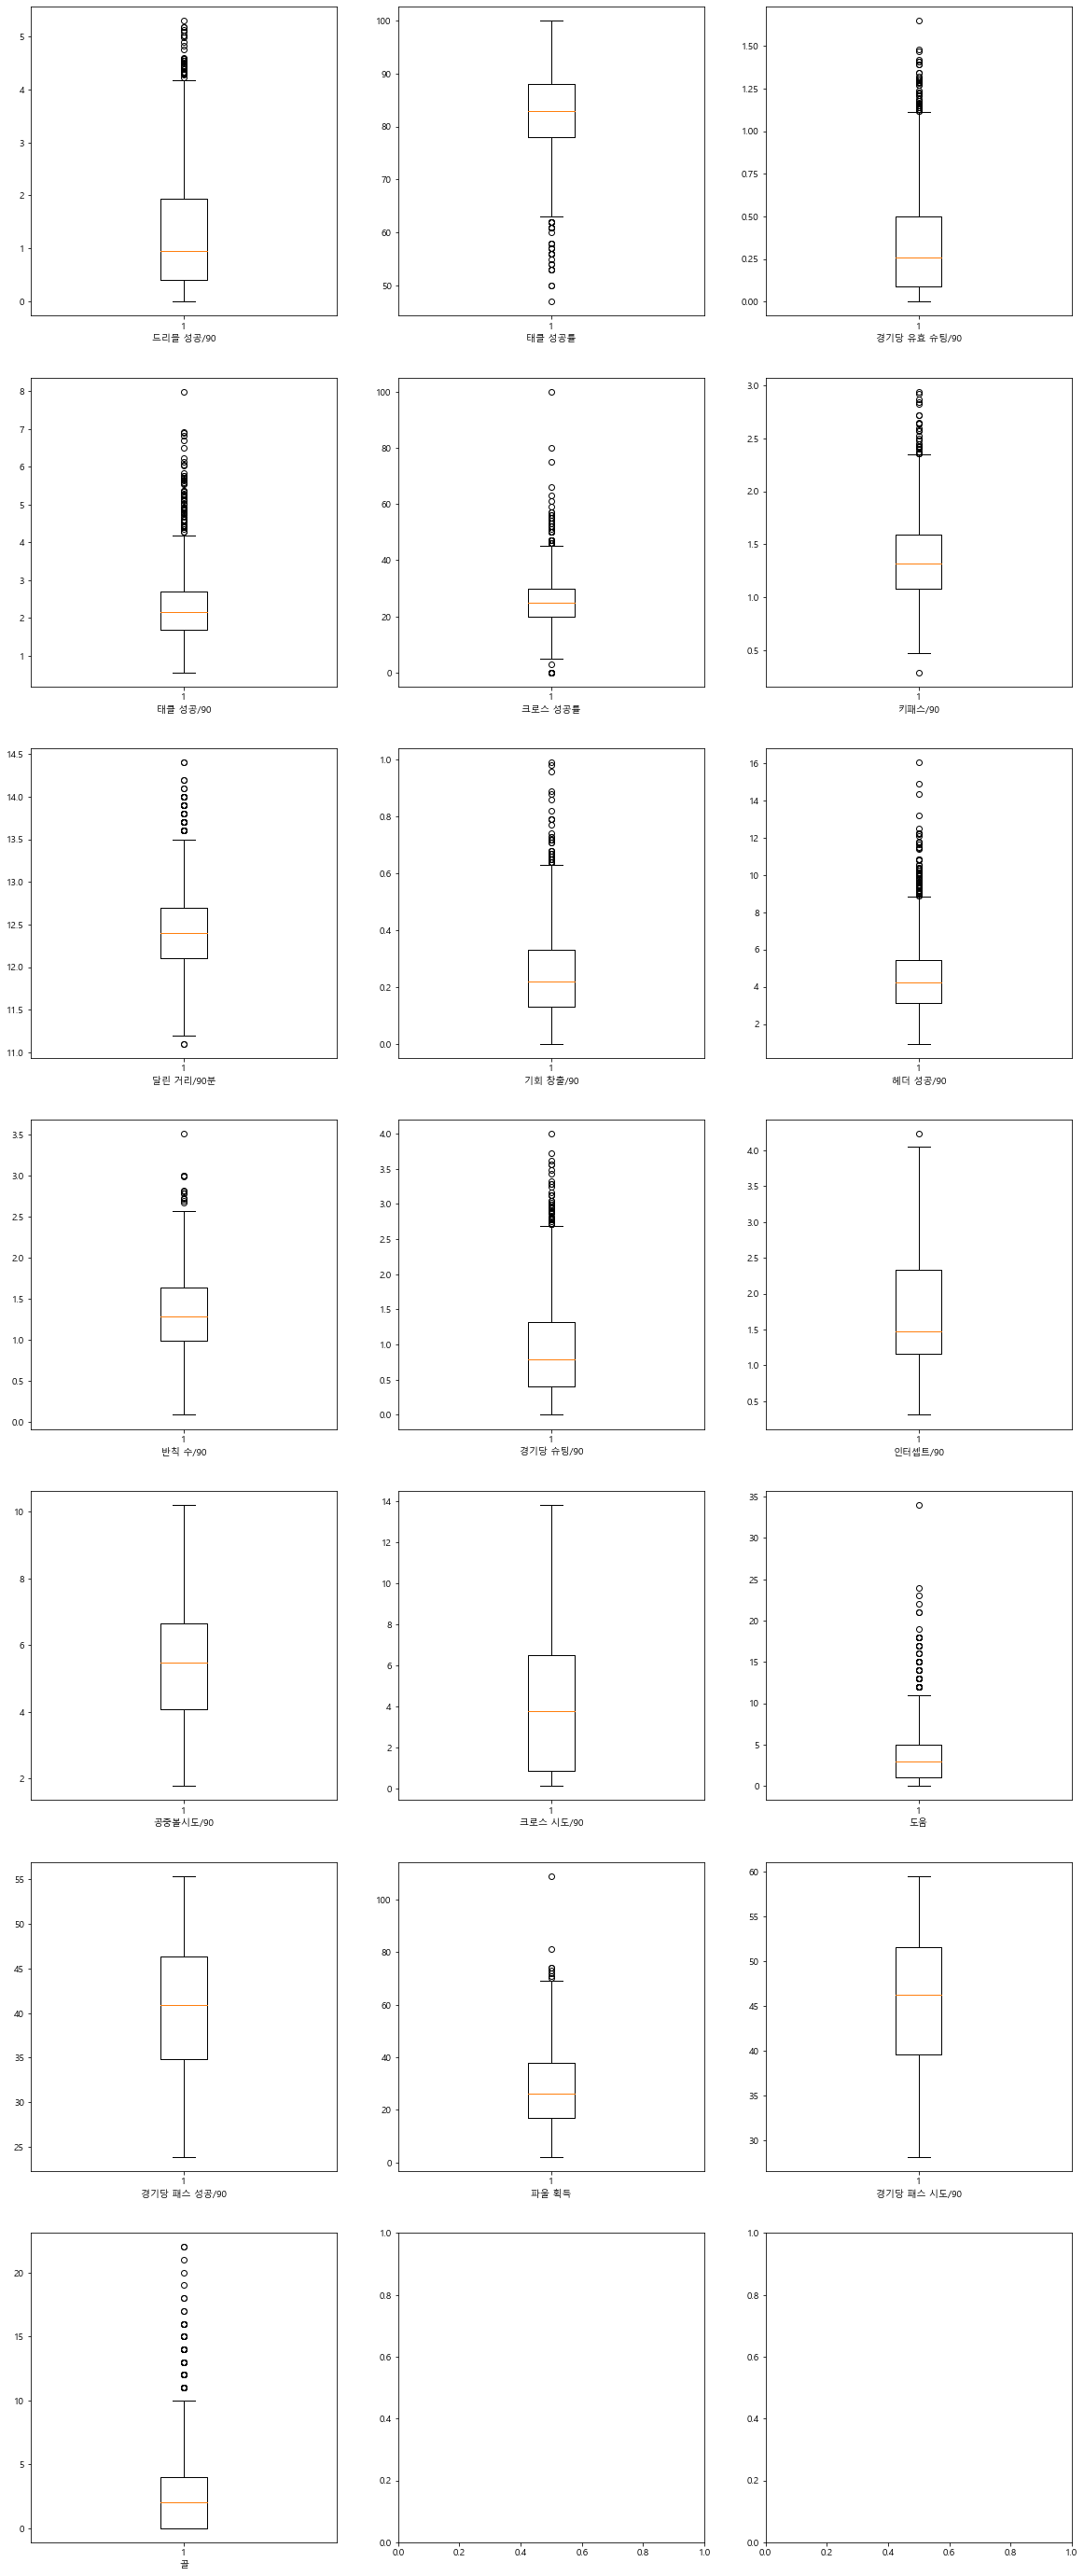

In [5]:
# 모든 변수의 Box plot 시각화

fig , axes = plt.subplots(7,3,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_xlabel(feature)
    ax.boxplot(midfielder_df.loc[:,feature])
    
plt.show()

In [6]:
# 데이터 당 이상치의 비율을 구하기
# 데이터는 990개인데 이상치가 그다지 많지 않다.
# 그래서 이상치의 비율이 5%가 넘는 변수만 tranformer를 적용한다.

out_ratio = defaultdict(float)

order_feature = ['골','도움']

for feature in set(features)-set(order_feature):
    
    data = midfielder_df[feature].to_numpy()   
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.7)
    low_bound = Q1 - 1.5 * (Q3-Q1)
    high_bound = Q3 + 1.5 * (Q3-Q1)
    out_ratio[feature] = (len(data[data>high_bound]) + len(data[data>=high_bound])) / len(data)

print(sorted(out_ratio.items(),key=lambda x : x[1],reverse=True))    
    
outlier_features = [k for k,v in out_ratio.items() if v > 0.05]
nonoutlier_features = list((set(features) - set(outlier_features)) -set(order_feature))

[('달린 거리/90분', 0.09890632429862102), ('드리블 성공/90', 0.0932001902044698), ('경기당 유효 슈팅/90', 0.08892058963385639), ('헤더 성공/90', 0.08368996671421779), ('태클 성공/90', 0.08368996671421779), ('기회 창출/90', 0.07513076557299096), ('경기당 슈팅/90', 0.07417974322396577), ('크로스 성공률', 0.06276747503566334), ('키패스/90', 0.04945316214931051), ('파울 획득', 0.04041844983357109), ('인터셉트/90', 0.019020446980504042), ('반칙 수/90', 0.01806942463147884), ('공중볼시도/90', 0.0028530670470756064), ('태클 성공률', 0.0), ('크로스 시도/90', 0.0), ('경기당 패스 성공/90', 0.0), ('경기당 패스 시도/90', 0.0)]


## 선형성 검정

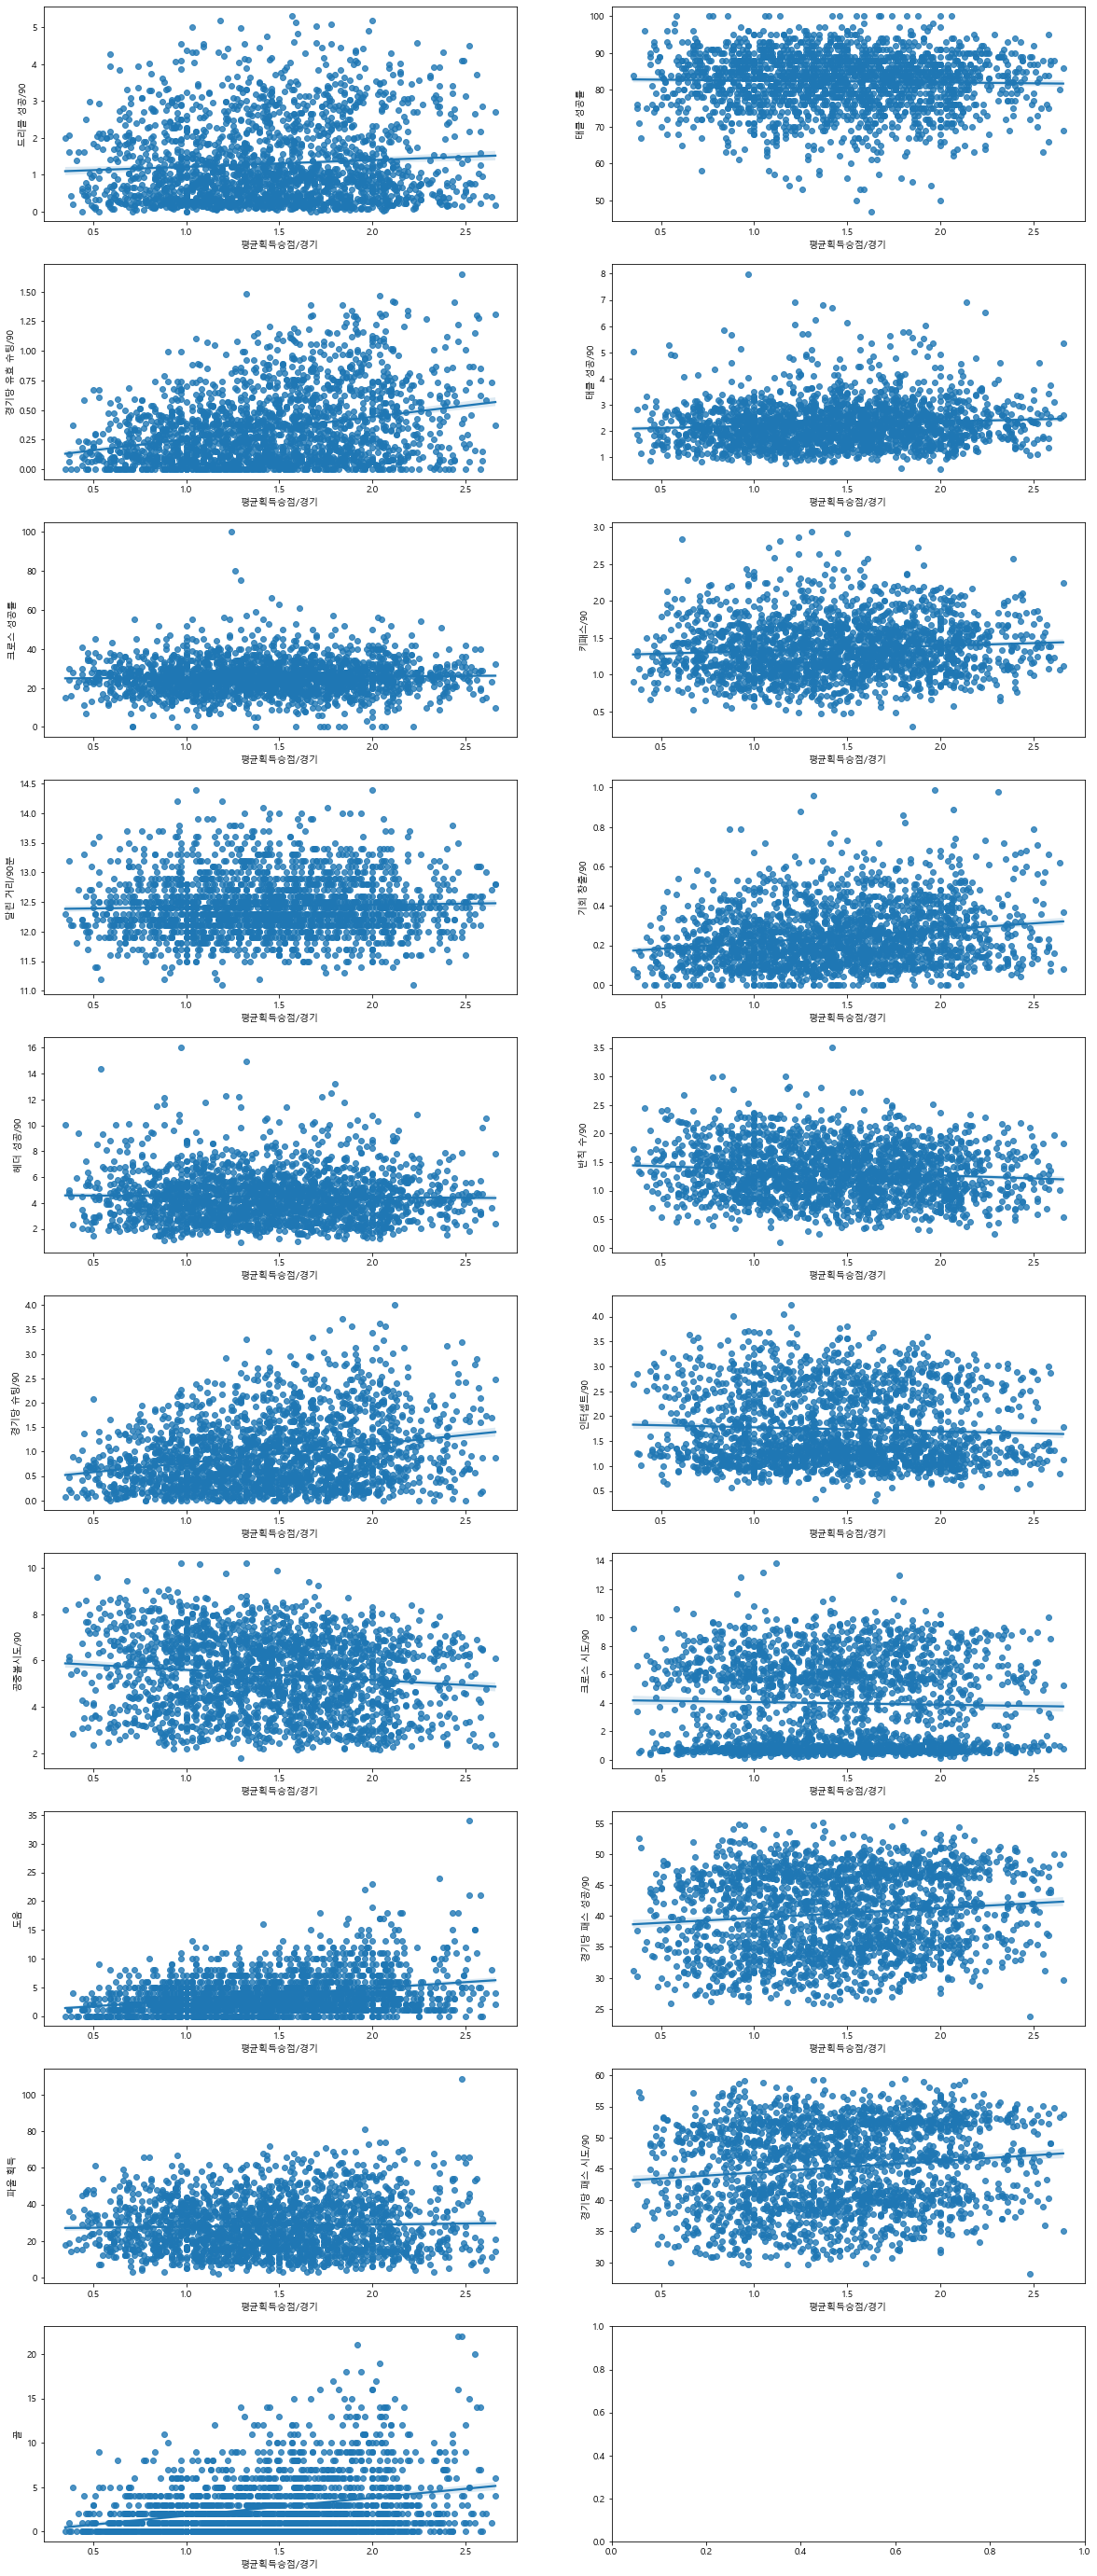

In [7]:
# scatter plot을 이용해서 선형성 검정
# 대부분의 피쳐가 선형성이 없어 보인다.

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    sns.regplot(midfielder_df.loc[:,target],midfielder_df.loc[:,feature],ax=ax)
    
plt.show()

In [8]:
# target value와의 correlation을 가지고 선형성 확인

corr = [np.corrcoef(x ,y=midfielder_df.loc[:,target].T.values)[0][1] for x in midfielder_df.loc[:,features].T.values]

corr_dict = {}

for i,v in enumerate(corr):
    corr_dict[features[i]] = v

sorted(corr_dict.items(),key = lambda x : x[1],reverse=True)

[('도움', 0.295910832213146),
 ('경기당 유효 슈팅/90', 0.29360684631635),
 ('골', 0.29165669928645965),
 ('경기당 슈팅/90', 0.26069549019921084),
 ('기회 창출/90', 0.20051106644558983),
 ('경기당 패스 시도/90', 0.12819276702582302),
 ('경기당 패스 성공/90', 0.11354758539719015),
 ('태클 성공/90', 0.09002394829529016),
 ('키패스/90', 0.08865750723338625),
 ('드리블 성공/90', 0.07912188896574465),
 ('달린 거리/90분', 0.03886594485891296),
 ('파울 획득', 0.0376774562711043),
 ('크로스 성공률', 0.031706900849534286),
 ('헤더 성공/90', -0.021514021662211936),
 ('크로스 시도/90', -0.028670787309705653),
 ('태클 성공률', -0.03018564085139023),
 ('인터셉트/90', -0.0527031909240161),
 ('반칙 수/90', -0.10936912583512294),
 ('공중볼시도/90', -0.12630171718848168)]

## 정규성 검정

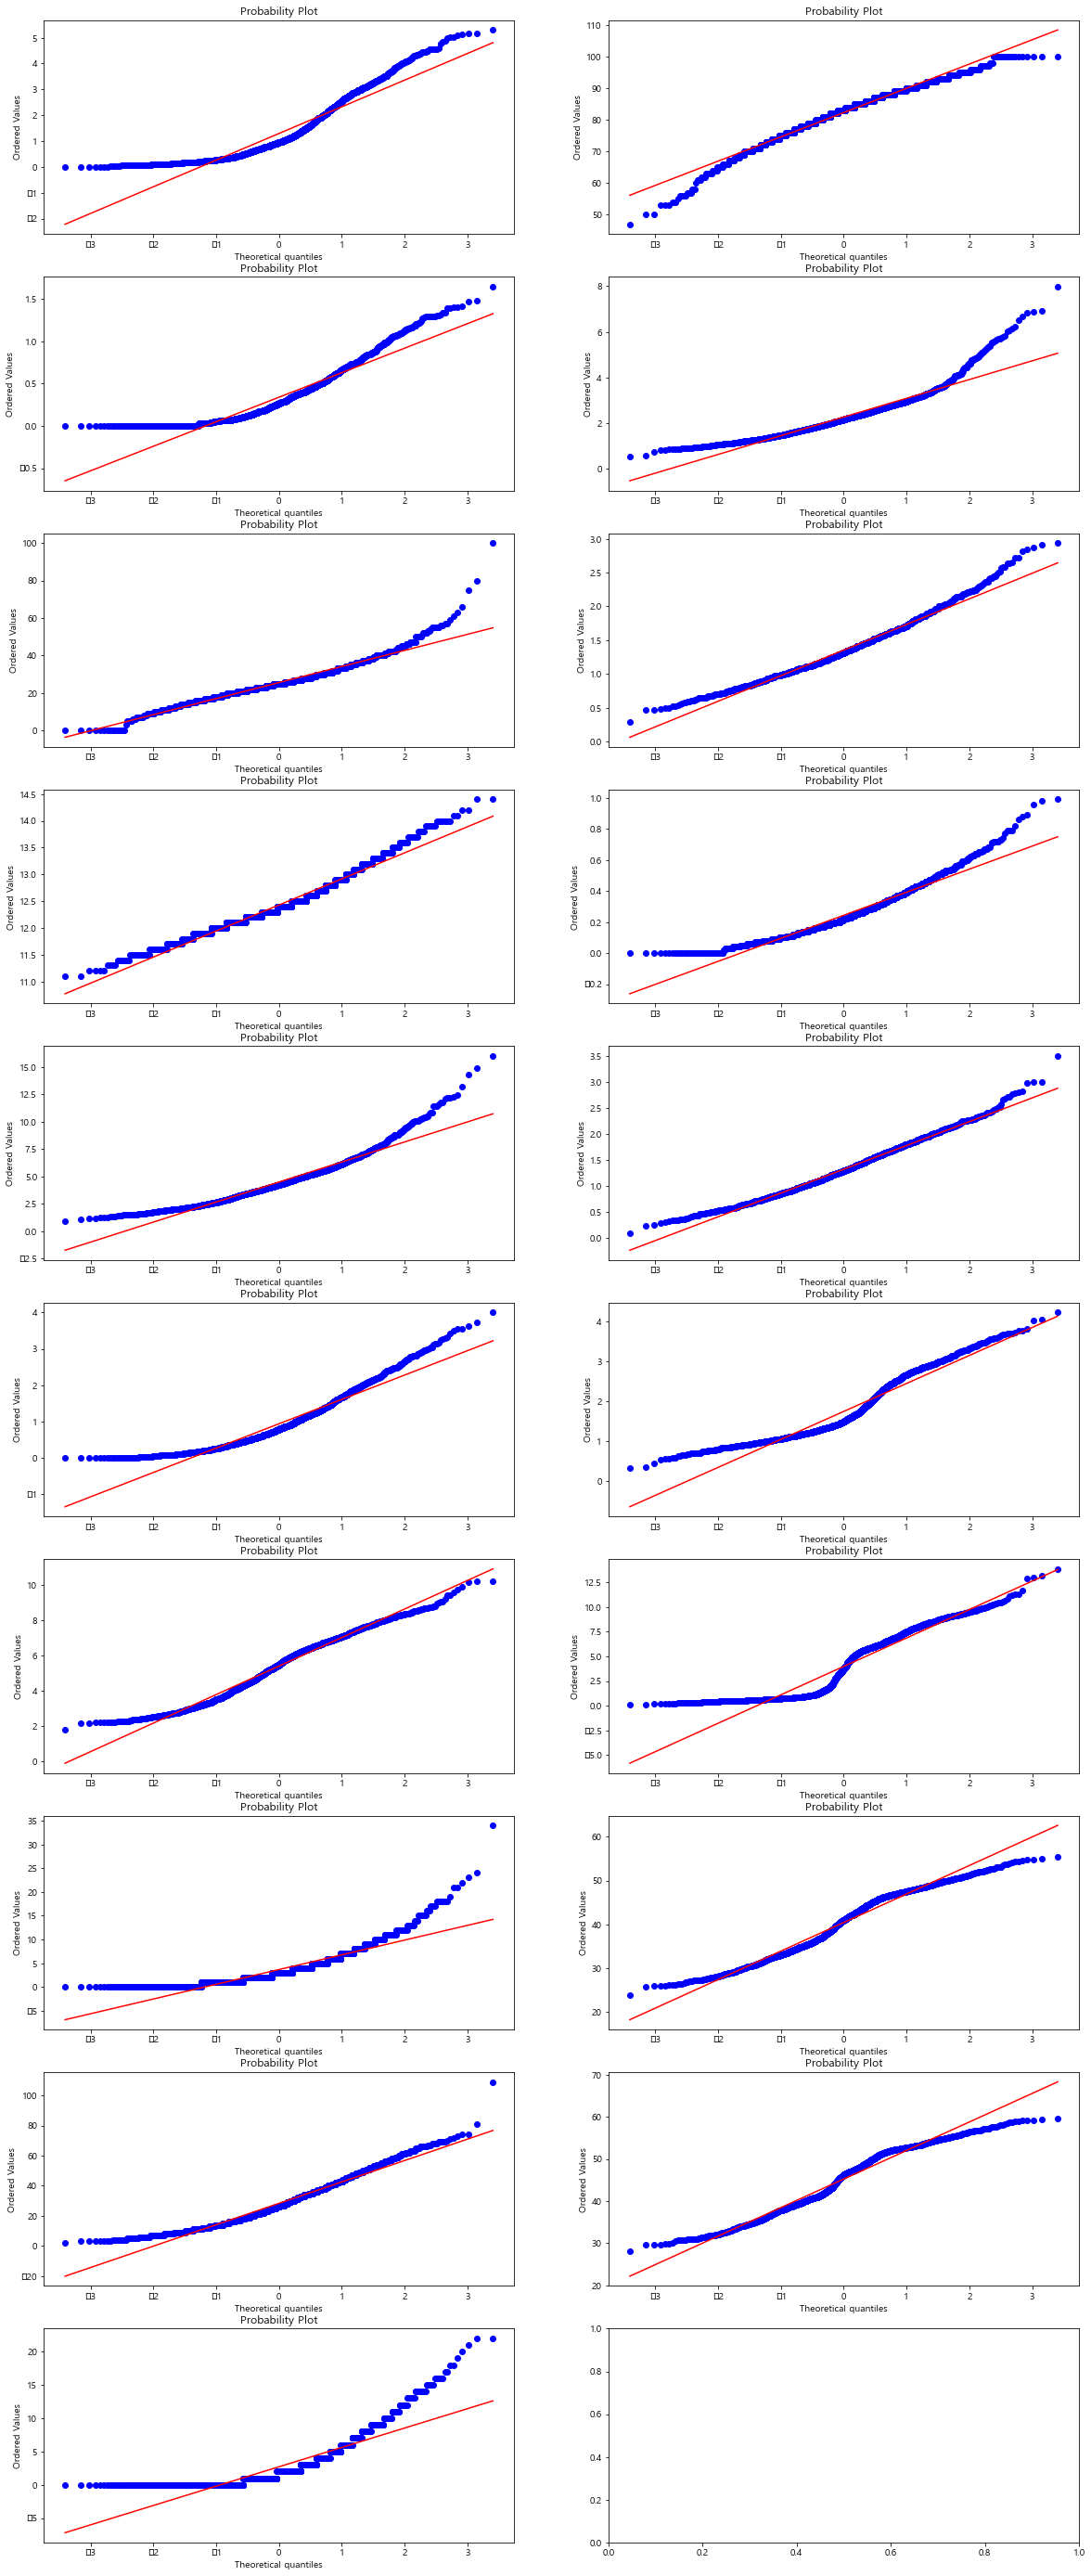

In [9]:
# QQ 플롯을 이용해서 정규성 시각화

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    stats.probplot(midfielder_df.loc[:,feature],dist='norm',plot=ax)
    
plt.show()

In [10]:
# 모든 변수가 정규성을 만족하지 않는다.

shapiro_dict = {}

for feature in features:
    shapiro_dict[feature] = stats.shapiro(midfielder_df.loc[:,feature])
      
for k,v in shapiro_dict.items():
    if v[1] > 0.05:
        print(f'{k} 은/는 정규성을 만족한다. {v[1]} \n',)
        
    else:
        print(f'{k} 은/는 정규성을 만족하지 않는다.  {v[1]} \n')

드리블 성공/90 은/는 정규성을 만족하지 않는다.  9.256467358480973e-37 

태클 성공률 은/는 정규성을 만족하지 않는다.  3.207678616076002e-18 

경기당 유효 슈팅/90 은/는 정규성을 만족하지 않는다.  2.555595030239399e-35 

태클 성공/90 은/는 정규성을 만족하지 않는다.  1.3805309631549227e-33 

크로스 성공률 은/는 정규성을 만족하지 않는다.  8.193307562927865e-25 

키패스/90 은/는 정규성을 만족하지 않는다.  1.9575737415835753e-16 

달린 거리/90분 은/는 정규성을 만족하지 않는다.  1.7932658525864493e-20 

기회 창출/90 은/는 정규성을 만족하지 않는다.  9.375083383374985e-27 

헤더 성공/90 은/는 정규성을 만족하지 않는다.  5.927479728823667e-29 

반칙 수/90 은/는 정규성을 만족하지 않는다.  7.500714632735495e-11 

경기당 슈팅/90 은/는 정규성을 만족하지 않는다.  5.396031115613518e-31 

인터셉트/90 은/는 정규성을 만족하지 않는다.  7.306543158545933e-32 

공중볼시도/90 은/는 정규성을 만족하지 않는다.  2.040851506328556e-16 

크로스 시도/90 은/는 정규성을 만족하지 않는다.  4.795395268093832e-36 

도움 은/는 정규성을 만족하지 않는다.  1.8054329414360943e-41 

경기당 패스 성공/90 은/는 정규성을 만족하지 않는다.  1.7133101626023545e-21 

파울 획득 은/는 정규성을 만족하지 않는다.  3.1309286007401646e-22 

경기당 패스 시도/90 은/는 정규성을 만족하지 않는다.  2.1539106118897544e-22 

골 은/는 정규성을 만족하지 않는다.  0.0 



## 등분산성 검정

In [11]:
# 변수간 등분산성을 만족하지 않는다.
stats.levene(*tuple([ tuple(x) for x in midfielder_df.loc[:,features].values]))

LeveneResult(statistic=0.047738686396583366, pvalue=0.9999999999999999)

## 다중 공선성 확인

In [12]:
this_vif = pd.DataFrame()
this_vif["VIF Factor"] = [vif(midfielder_df.loc[:,features].values,i) for i in range(midfielder_df.loc[:,features].values.shape[1])]
this_vif["feautures"] = midfielder_df.loc[:,features].columns
this_vif = this_vif.sort_values("VIF Factor").reset_index(drop=True)
this_vif

,VIF Factor,feautures
0,3.922823,도움
1,5.523605,기회 창출/90
2,6.152678,드리블 성공/90
3,6.226425,골
4,10.462804,크로스 성공률
5,10.548021,파울 획득
6,11.322190,반칙 수/90
7,12.869279,크로스 시도/90
8,20.234387,키패스/90
9,20.643033,태클 성공/90


## 변수 정규화 및 변수 선택

### 변수 정규화

In [13]:
norm_midfielder_df = midfielder_df.copy()

midfielder_mm = MinMaxScaler().fit(norm_midfielder_df.loc[:,order_feature])
norm_midfielder_df.loc[:,order_feature] = midfielder_mm.transform(norm_midfielder_df.loc[:,order_feature])

midfielder_qt = QuantileTransformer(n_quantiles=100,output_distribution='normal').fit(norm_midfielder_df.loc[:,outlier_features])
norm_midfielder_df.loc[:,outlier_features] = midfielder_qt.transform(norm_midfielder_df.loc[:,outlier_features])

midfielder_ss = StandardScaler().fit(norm_midfielder_df.loc[:,nonoutlier_features])
norm_midfielder_df.loc[:,nonoutlier_features] = midfielder_ss.transform(norm_midfielder_df.loc[:,nonoutlier_features])

In [14]:
with open('./models/midfielder_qt.pickle','wb') as f:
    pickle.dump(midfielder_qt,f)
    
with open('./models/midfielder_ss.pickle','wb') as f:
    pickle.dump(midfielder_ss,f)
    
with open('./models/midfielder_mm.pickle','wb') as f:
    pickle.dump(midfielder_mm,f)

In [15]:
outlier_features

['헤더 성공/90',
 '경기당 슈팅/90',
 '드리블 성공/90',
 '경기당 유효 슈팅/90',
 '태클 성공/90',
 '크로스 성공률',
 '달린 거리/90분',
 '기회 창출/90']

In [16]:
nonoutlier_features

['경기당 패스 성공/90',
 '반칙 수/90',
 '파울 획득',
 '경기당 패스 시도/90',
 '인터셉트/90',
 '공중볼시도/90',
 '크로스 시도/90',
 '태클 성공률',
 '키패스/90']

In [17]:
order_feature

['골', '도움']

### 상관계수와 시각화를 통한 변수 선택

In [18]:
feature_comb = list(combinations(features,2))

In [20]:
'''
fig , axes = plt.subplots(43,4,figsize=(100,860))

for i,(ax,feature) in enumerate(zip(axes.ravel(),feature_comb)):
    sns.scatterplot(x = midfielder_df.loc[:,feature[0]], y= midfielder_df.loc[:,feature[1]],ax=ax)
'''

'\nfig , axes = plt.subplots(43,4,figsize=(100,860))\n\nfor i,(ax,feature) in enumerate(zip(axes.ravel(),feature_comb)):\n    sns.scatterplot(x = midfielder_df.loc[:,feature[0]], y= midfielder_df.loc[:,feature[1]],ax=ax)\n'

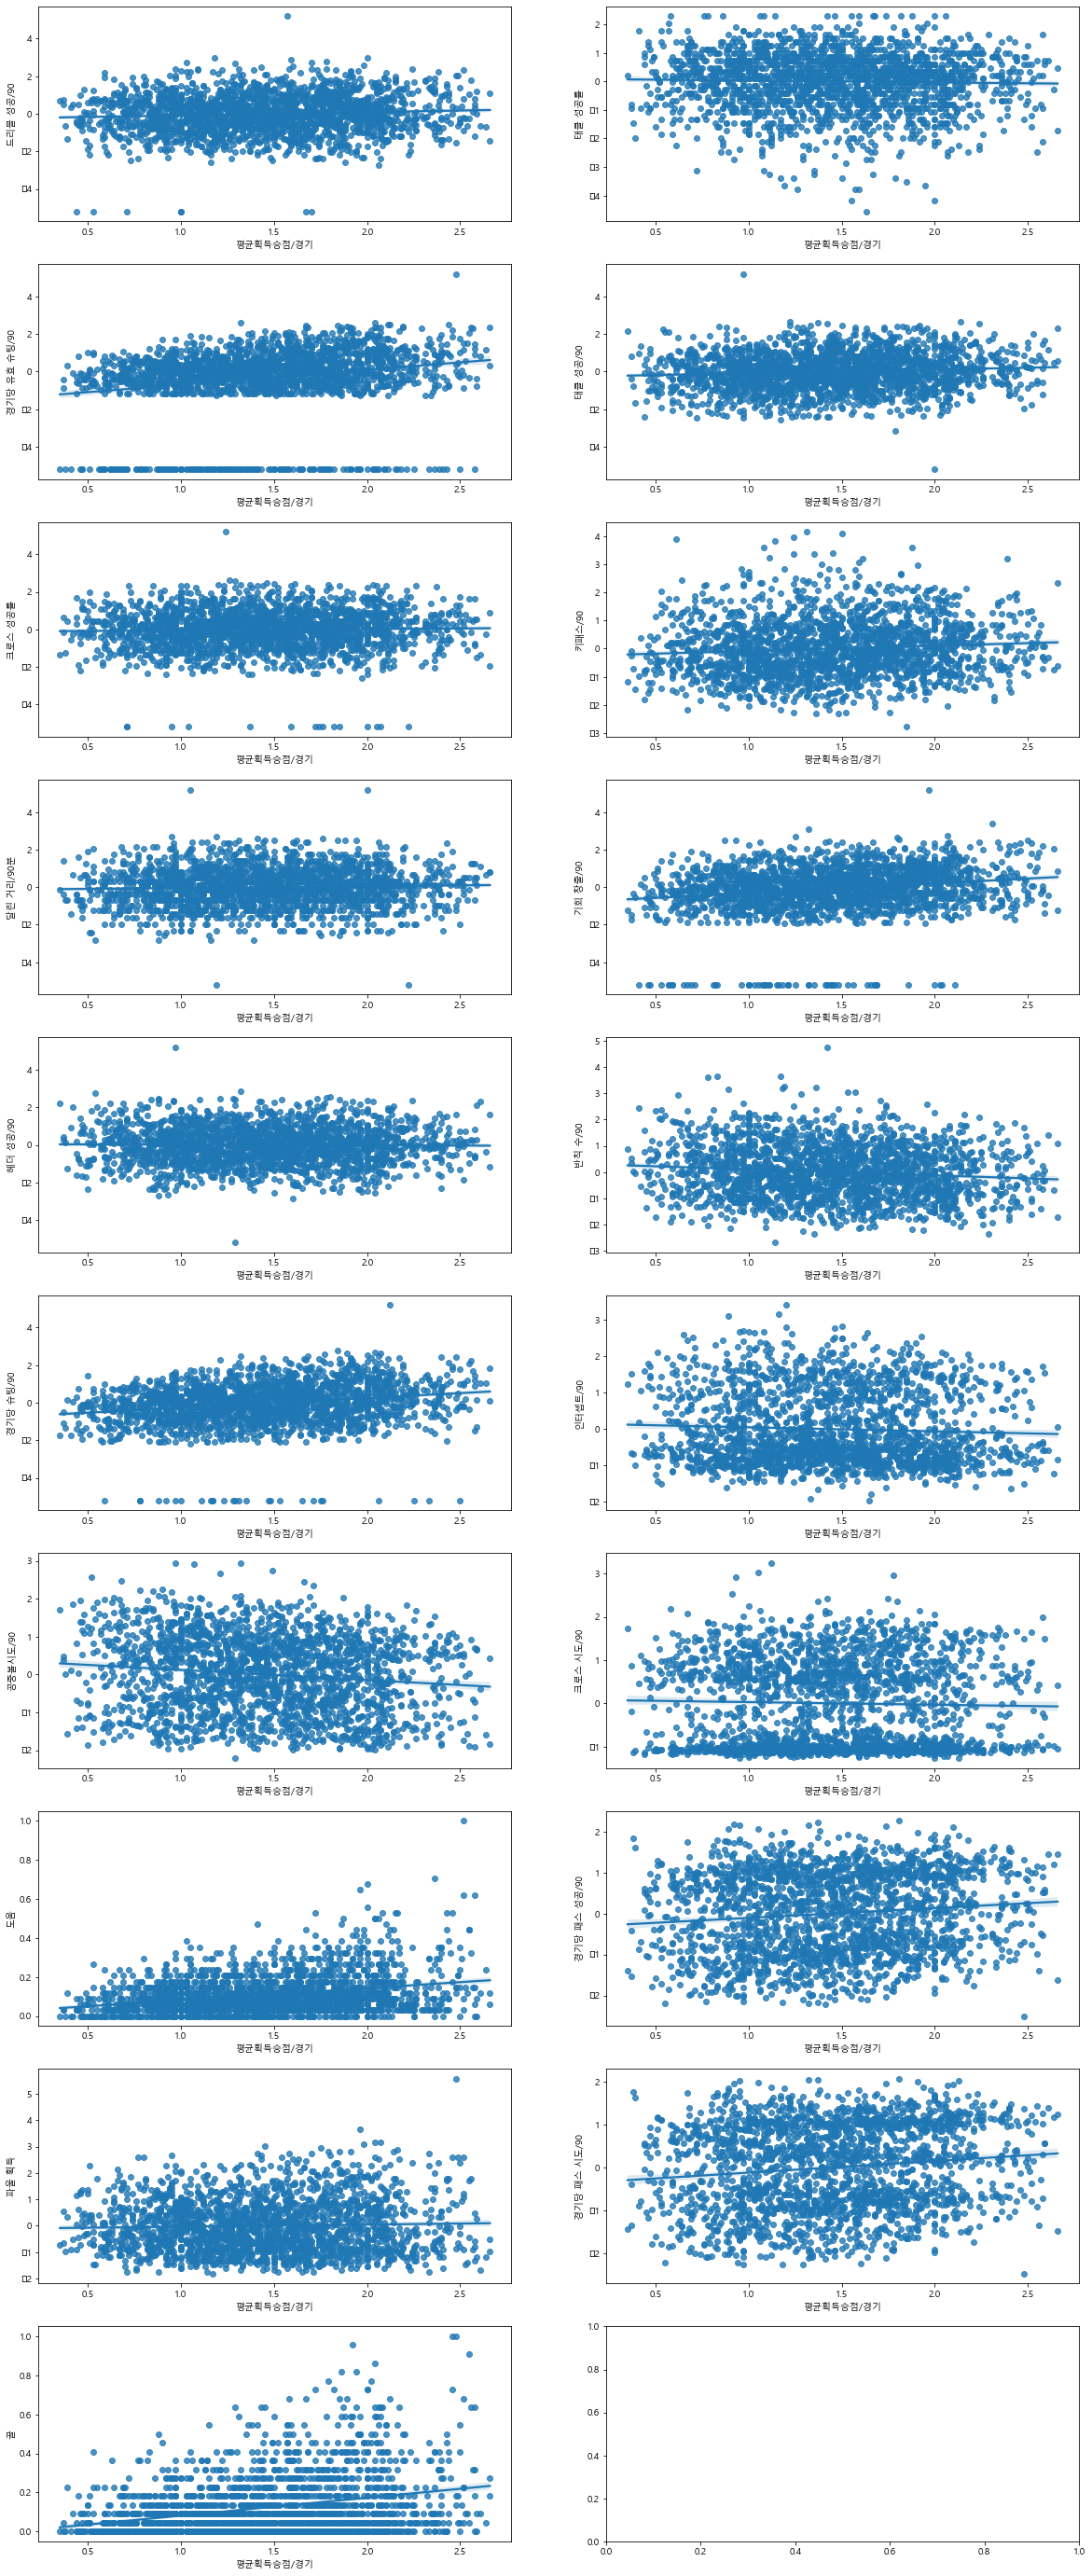

In [21]:
fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),features)) :
    ax.set_ylabel(feature)
    ax.set_xlabel(target)
    sns.regplot(norm_midfielder_df.loc[:,target],norm_midfielder_df.loc[:,feature],ax=ax)
    
plt.show()

In [40]:
corr_dict_after_norm = {}

for feature in features:
    corr_dict_after_norm[f'헤더 성공/90/{feature}'] = np.corrcoef(midfielder_df.loc[:,'헤더 성공/90'],midfielder_df.loc[:,feature])[0][1]
    
sorted(corr_dict_after_norm.items(),key=lambda x : np.abs(x[1]),reverse=True)

[('헤더 성공/90/헤더 성공/90', 1.0),
 ('헤더 성공/90/공중볼시도/90', 0.7083701445966264),
 ('헤더 성공/90/태클 성공/90', 0.616254804402742),
 ('헤더 성공/90/크로스 시도/90', 0.4337741827543684),
 ('헤더 성공/90/인터셉트/90', 0.40285302967867614),
 ('헤더 성공/90/경기당 패스 시도/90', -0.37149470874188495),
 ('헤더 성공/90/경기당 패스 성공/90', -0.3510173668125441),
 ('헤더 성공/90/도움', -0.3438220314025103),
 ('헤더 성공/90/골', -0.31769938764774286),
 ('헤더 성공/90/기회 창출/90', -0.25109741493708476),
 ('헤더 성공/90/드리블 성공/90', 0.23033378497718285),
 ('헤더 성공/90/경기당 유효 슈팅/90', -0.2226637745366787),
 ('헤더 성공/90/태클 성공률', 0.21592092727203238),
 ('헤더 성공/90/파울 획득', -0.1883998272008738),
 ('헤더 성공/90/경기당 슈팅/90', -0.18597022062833587),
 ('헤더 성공/90/반칙 수/90', 0.15864928678188828),
 ('헤더 성공/90/달린 거리/90분', -0.09889277301456563),
 ('헤더 성공/90/크로스 성공률', -0.09782622959618946),
 ('헤더 성공/90/키패스/90', 0.05106685462330368)]

In [22]:
sorted(corr_dict.items(),key=lambda x : np.abs(x[1]),reverse=True)

[('도움', 0.295910832213146),
 ('경기당 유효 슈팅/90', 0.29360684631635),
 ('골', 0.29165669928645965),
 ('경기당 슈팅/90', 0.26069549019921084),
 ('기회 창출/90', 0.20051106644558983),
 ('경기당 패스 시도/90', 0.12819276702582302),
 ('공중볼시도/90', -0.12630171718848168),
 ('경기당 패스 성공/90', 0.11354758539719015),
 ('반칙 수/90', -0.10936912583512294),
 ('태클 성공/90', 0.09002394829529016),
 ('키패스/90', 0.08865750723338625),
 ('드리블 성공/90', 0.07912188896574465),
 ('인터셉트/90', -0.0527031909240161),
 ('달린 거리/90분', 0.03886594485891296),
 ('파울 획득', 0.0376774562711043),
 ('크로스 성공률', 0.031706900849534286),
 ('태클 성공률', -0.03018564085139023),
 ('크로스 시도/90', -0.028670787309705653),
 ('헤더 성공/90', -0.021514021662211936)]

In [48]:
len(midfielder_df)

2103

In [49]:
# 상관계수가 높은 변수
# 전진선택법을 위한 변수의 우선순위 순 
good_feature_order = ['도움','경기당 유효 슈팅/90','경기당 패스 시도/90','반칙 수/90','태클 성공/90','키패스/90','달린 거리/90분',
                     '파울 획득','크로스 성공률','헤더 성공/90']

checkpoint_filepath = './tmp/'

midfielder_mae = []
midfielder_model = []

for i in range(1,len(good_feature_order)+1):
    
    print(good_feature_order[:i])
    
    fx_train,fx_test,fy_train,fy_test = train_test_split(norm_midfielder_df.loc[:,good_feature_order[:i]],norm_midfielder_df.loc[:,target],test_size=0.2)
    
    inputs_layer = Input(shape=(i,))
    hidden1 = Dense(128,activation='swish')(inputs_layer)
    hidden2 = Dense(64,activation='swish')(hidden1)
    hidden3 = Dense(32,activation='swish')(hidden2)
    output = Dense(1,activation='linear')(hidden3)
    model = Model(inputs=[inputs_layer],outputs=[output])
    model.compile(loss='mse',optimizer=Adam(lr=0.001))
    
    
    model.fit(fx_train,fy_train,batch_size=200,epochs=50,validation_data=(fx_test,fy_test))  
    predict_result=model.predict(fx_test)
    mae = mean_absolute_error(fy_test,predict_result)
    midfielder_mae.append(mae)
    midfielder_model.append(model)

['도움']
Epoch 1/50
9/9 [==============================] - 0s 18ms/step - loss: 2.2233 - val_loss: 2.0556
Epoch 2/50
9/9 [==============================] - 0s 6ms/step - loss: 1.8680 - val_loss: 1.6001
Epoch 3/50
9/9 [==============================] - 0s 7ms/step - loss: 1.3048 - val_loss: 0.9108
Epoch 4/50
9/9 [==============================] - 0s 7ms/step - loss: 0.5804 - val_loss: 0.2807
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 0.2478 - val_loss: 0.2919
Epoch 6/50
9/9 [==============================] - 0s 7ms/step - loss: 0.2680 - val_loss: 0.2234
Epoch 7/50
9/9 [==============================] - 0s 7ms/step - loss: 0.2151 - val_loss: 0.2389
Epoch 8/50
9/9 [==============================] - 0s 7ms/step - loss: 0.2183 - val_loss: 0.2245
Epoch 9/50
9/9 [==============================] - 0s 7ms/step - loss: 0.2098 - val_loss: 0.2188
Epoch 10/50
9/9 [==============================] - 0s 8ms/step - loss: 0.2083 - val_loss: 0.2175
Epoch 11/50
9/9 [==============

9/9 [==============================] - 0s 7ms/step - loss: 0.1932 - val_loss: 0.2148
Epoch 36/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1942 - val_loss: 0.2117
Epoch 37/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1915 - val_loss: 0.2108
Epoch 38/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1923 - val_loss: 0.2105
Epoch 39/50
9/9 [==============================] - 0s 8ms/step - loss: 0.1926 - val_loss: 0.2104
Epoch 40/50
9/9 [==============================] - 0s 8ms/step - loss: 0.1922 - val_loss: 0.2120
Epoch 41/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1913 - val_loss: 0.2108
Epoch 42/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1927 - val_loss: 0.2115
Epoch 43/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1924 - val_loss: 0.2119
Epoch 44/50
9/9 [==============================] - 0s 8ms/step - loss: 0.1942 - val_loss: 0.2102
Epoch 45/50
9/9 [=========================

Epoch 19/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1928 - val_loss: 0.2016
Epoch 20/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1923 - val_loss: 0.2050
Epoch 21/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1924 - val_loss: 0.2016
Epoch 22/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1928 - val_loss: 0.2044
Epoch 23/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1909 - val_loss: 0.2012
Epoch 24/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1918 - val_loss: 0.2005
Epoch 25/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1895 - val_loss: 0.2001
Epoch 26/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1887 - val_loss: 0.2010
Epoch 27/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1881 - val_loss: 0.2009
Epoch 28/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1880 - val_loss: 0.2004
Epoch 29/50
9/9 [=============

9/9 [==============================] - 0s 7ms/step - loss: 1.5122 - val_loss: 1.0752
Epoch 3/50
9/9 [==============================] - 0s 7ms/step - loss: 0.8929 - val_loss: 0.5479
Epoch 4/50
9/9 [==============================] - 0s 6ms/step - loss: 0.4863 - val_loss: 0.3871
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 0.4025 - val_loss: 0.3352
Epoch 6/50
9/9 [==============================] - 0s 6ms/step - loss: 0.3291 - val_loss: 0.2577
Epoch 7/50
9/9 [==============================] - 0s 7ms/step - loss: 0.2771 - val_loss: 0.2281
Epoch 8/50
9/9 [==============================] - 0s 7ms/step - loss: 0.2432 - val_loss: 0.2066
Epoch 9/50
9/9 [==============================] - 0s 7ms/step - loss: 0.2243 - val_loss: 0.1931
Epoch 10/50
9/9 [==============================] - 0s 7ms/step - loss: 0.2106 - val_loss: 0.1844
Epoch 11/50
9/9 [==============================] - 0s 7ms/step - loss: 0.2011 - val_loss: 0.1762
Epoch 12/50
9/9 [==============================] 

Epoch 36/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1661 - val_loss: 0.1717
Epoch 37/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1655 - val_loss: 0.1737
Epoch 38/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1652 - val_loss: 0.1730
Epoch 39/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1661 - val_loss: 0.1712
Epoch 40/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1648 - val_loss: 0.1716
Epoch 41/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1644 - val_loss: 0.1726
Epoch 42/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1653 - val_loss: 0.1719
Epoch 43/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1643 - val_loss: 0.1740
Epoch 44/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1643 - val_loss: 0.1721
Epoch 45/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1657 - val_loss: 0.1715
Epoch 46/50
9/9 [=============

9/9 [==============================] - 0s 7ms/step - loss: 0.1722 - val_loss: 0.1715
Epoch 19/50
9/9 [==============================] - 0s 7ms/step - loss: 0.1699 - val_loss: 0.1717
Epoch 20/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1686 - val_loss: 0.1708
Epoch 21/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1677 - val_loss: 0.1692
Epoch 22/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1667 - val_loss: 0.1683
Epoch 23/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1668 - val_loss: 0.1701
Epoch 24/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1650 - val_loss: 0.1684
Epoch 25/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1647 - val_loss: 0.1681
Epoch 26/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1644 - val_loss: 0.1687
Epoch 27/50
9/9 [==============================] - 0s 6ms/step - loss: 0.1641 - val_loss: 0.1665
Epoch 28/50
9/9 [=========================

In [50]:
midfielder_mae

[0.3783921410408835,
 0.3807317822789353,
 0.34090853560848644,
 0.36607880630855605,
 0.3276592202990751,
 0.324000996784473,
 0.33298924779099126,
 0.3426447596855798,
 0.3353971076408078,
 0.3505532948534732]

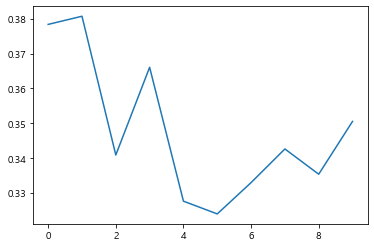

In [51]:
plt.plot(midfielder_mae)
plt.show()

In [52]:
good_features = good_feature_order[0:np.argmin(np.array(midfielder_mae))]
#good_features.append(good_feature_order[6])
good_features

['도움', '경기당 유효 슈팅/90', '경기당 패스 시도/90', '반칙 수/90', '태클 성공/90']

In [53]:
fx_train,fx_test,fy_train,fy_test = train_test_split(norm_midfielder_df.loc[:,good_features],norm_midfielder_df.loc[:,target],test_size=0.2)

In [54]:
inputs_layer = Input(shape=(len(good_features),))
hidden1 = Dense(256,activation='swish')(inputs_layer)
hidden2 = Dense(512,activation='swish')(hidden1)
hidden3 = Dropout(0.1)(hidden2)
hidden4 = Dense(1024,activation='swish',kernel_regularizer=L2(l2=0.01))(hidden3)
hidden5 = Dense(2048,activation='swish',kernel_regularizer=L2(l2=0.01))(hidden4)
hidden6 = Dropout(0.1)(hidden5)
hidden7 = Dense(1024,activation='swish')(hidden6)
hidden8 = Dense(512,activation='swish')(hidden7)
hidden9 = Dense(256,activation='swish')(hidden8)
hidden10 = Dense(128,activation='swish')(hidden9)
hidden11 = Dense(4,activation='swish')(hidden10)
output = Dense(1,activation='linear')(hidden11)
model = Model(inputs=[inputs_layer],outputs=[output])
model.compile(loss='mse',optimizer=Adam(lr=0.0005)) 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=100)
model.fit(fx_train,fy_train,batch_size=200,epochs=1000,validation_data=(fx_test,fy_test))  
predict_result=model.predict(fx_test)
mae = mean_absolute_error(fy_test,predict_result)
print(mae)
model.save('./models/midfielder_nn.h5')

Epoch 1/1000
9/9 [==============================] - 1s 47ms/step - loss: 20.4044 - val_loss: 16.7169
Epoch 2/1000
9/9 [==============================] - 0s 14ms/step - loss: 14.3519 - val_loss: 11.7924
Epoch 3/1000
9/9 [==============================] - 0s 14ms/step - loss: 10.5221 - val_loss: 8.8020
Epoch 4/1000
9/9 [==============================] - 0s 14ms/step - loss: 7.8152 - val_loss: 6.4977
Epoch 5/1000
9/9 [==============================] - 0s 14ms/step - loss: 5.7565 - val_loss: 4.7577
Epoch 6/1000
9/9 [==============================] - 0s 14ms/step - loss: 4.2105 - val_loss: 3.4745
Epoch 7/1000
9/9 [==============================] - 0s 14ms/step - loss: 3.0715 - val_loss: 2.5308
Epoch 8/1000
9/9 [==============================] - 0s 14ms/step - loss: 2.2450 - val_loss: 1.8532
Epoch 9/1000
9/9 [==============================] - 0s 14ms/step - loss: 1.6494 - val_loss: 1.3679
Epoch 10/1000
9/9 [==============================] - 0s 14ms/step - loss: 1.2261 - val_loss: 1.0234
Epoc

Epoch 83/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1765 - val_loss: 0.1742
Epoch 84/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1773 - val_loss: 0.1710
Epoch 85/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1784 - val_loss: 0.1784
Epoch 86/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1819 - val_loss: 0.1721
Epoch 87/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1805 - val_loss: 0.1763
Epoch 88/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1797 - val_loss: 0.1749
Epoch 89/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1797 - val_loss: 0.1760
Epoch 90/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1807 - val_loss: 0.1752
Epoch 91/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1800 - val_loss: 0.1730
Epoch 92/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1797 - val_loss: 0.1788


9/9 [==============================] - 0s 14ms/step - loss: 0.1739 - val_loss: 0.1676
Epoch 165/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1750 - val_loss: 0.1688
Epoch 166/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1750 - val_loss: 0.1736
Epoch 167/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1751 - val_loss: 0.1709
Epoch 168/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1740 - val_loss: 0.1687
Epoch 169/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1737 - val_loss: 0.1699
Epoch 170/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.1736 - val_loss: 0.1700
Epoch 171/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1724 - val_loss: 0.1897
Epoch 172/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1833 - val_loss: 0.1730
Epoch 173/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1756 - val_loss: 0.1728
Epoch

9/9 [==============================] - 0s 14ms/step - loss: 0.1713 - val_loss: 0.1708
Epoch 246/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1714 - val_loss: 0.1720
Epoch 247/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1734 - val_loss: 0.1701
Epoch 248/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1750 - val_loss: 0.1681
Epoch 249/1000
9/9 [==============================] - 0s 16ms/step - loss: 0.1725 - val_loss: 0.1699
Epoch 250/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1716 - val_loss: 0.1679
Epoch 251/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.1711 - val_loss: 0.1662
Epoch 252/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1710 - val_loss: 0.1665
Epoch 253/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1718 - val_loss: 0.1681
Epoch 254/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1732 - val_loss: 0.1699
Epoch

9/9 [==============================] - 0s 15ms/step - loss: 0.1697 - val_loss: 0.1656
Epoch 327/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1687 - val_loss: 0.1667
Epoch 328/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1690 - val_loss: 0.1679
Epoch 329/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1716 - val_loss: 0.1695
Epoch 330/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1705 - val_loss: 0.1650
Epoch 331/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1689 - val_loss: 0.1664
Epoch 332/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1682 - val_loss: 0.1685
Epoch 333/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1696 - val_loss: 0.1676
Epoch 334/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1688 - val_loss: 0.1651
Epoch 335/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1684 - val_loss: 0.1657
Epoch

9/9 [==============================] - 0s 14ms/step - loss: 0.1722 - val_loss: 0.1741
Epoch 408/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1702 - val_loss: 0.1701
Epoch 409/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1723 - val_loss: 0.1691
Epoch 410/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1714 - val_loss: 0.1671
Epoch 411/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1693 - val_loss: 0.1686
Epoch 412/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1699 - val_loss: 0.1668
Epoch 413/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1688 - val_loss: 0.1705
Epoch 414/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1692 - val_loss: 0.1675
Epoch 415/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1686 - val_loss: 0.1663
Epoch 416/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1685 - val_loss: 0.1673
Epoch

9/9 [==============================] - 0s 14ms/step - loss: 0.1672 - val_loss: 0.1658
Epoch 489/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1677 - val_loss: 0.1674
Epoch 490/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1688 - val_loss: 0.1665
Epoch 491/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1721 - val_loss: 0.1693
Epoch 492/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1730 - val_loss: 0.1714
Epoch 493/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1719 - val_loss: 0.1730
Epoch 494/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1702 - val_loss: 0.1693
Epoch 495/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1703 - val_loss: 0.1678
Epoch 496/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1683 - val_loss: 0.1689
Epoch 497/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1725 - val_loss: 0.1702
Epoch

9/9 [==============================] - 0s 14ms/step - loss: 0.1677 - val_loss: 0.1765
Epoch 570/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1717 - val_loss: 0.1692
Epoch 571/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1672 - val_loss: 0.1685
Epoch 572/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1665 - val_loss: 0.1661
Epoch 573/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1663 - val_loss: 0.1657
Epoch 574/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1654 - val_loss: 0.1646
Epoch 575/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1660 - val_loss: 0.1658
Epoch 576/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1650 - val_loss: 0.1658
Epoch 577/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1643 - val_loss: 0.1658
Epoch 578/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1653 - val_loss: 0.1650
Epoch

9/9 [==============================] - 0s 14ms/step - loss: 0.1636 - val_loss: 0.1672
Epoch 651/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1671 - val_loss: 0.1699
Epoch 652/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1664 - val_loss: 0.1681
Epoch 653/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1668 - val_loss: 0.1702
Epoch 654/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1685 - val_loss: 0.1655
Epoch 655/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1667 - val_loss: 0.1732
Epoch 656/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1673 - val_loss: 0.1666
Epoch 657/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1648 - val_loss: 0.1691
Epoch 658/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1648 - val_loss: 0.1679
Epoch 659/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1644 - val_loss: 0.1663
Epoch

9/9 [==============================] - 0s 14ms/step - loss: 0.1638 - val_loss: 0.1696
Epoch 732/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1638 - val_loss: 0.1669
Epoch 733/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1639 - val_loss: 0.1687
Epoch 734/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1630 - val_loss: 0.1684
Epoch 735/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1629 - val_loss: 0.1677
Epoch 736/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1628 - val_loss: 0.1691
Epoch 737/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1644 - val_loss: 0.1684
Epoch 738/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.1639 - val_loss: 0.1671
Epoch 739/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1625 - val_loss: 0.1685
Epoch 740/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1640 - val_loss: 0.1695
Epoch

9/9 [==============================] - 0s 14ms/step - loss: 0.1654 - val_loss: 0.1687
Epoch 813/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1633 - val_loss: 0.1704
Epoch 814/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1624 - val_loss: 0.1697
Epoch 815/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1615 - val_loss: 0.1710
Epoch 816/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1634 - val_loss: 0.1680
Epoch 817/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1636 - val_loss: 0.1686
Epoch 818/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1624 - val_loss: 0.1683
Epoch 819/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1632 - val_loss: 0.1715
Epoch 820/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1641 - val_loss: 0.1714
Epoch 821/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1632 - val_loss: 0.1701
Epoch

9/9 [==============================] - 0s 14ms/step - loss: 0.1622 - val_loss: 0.1696
Epoch 894/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1605 - val_loss: 0.1705
Epoch 895/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1624 - val_loss: 0.1706
Epoch 896/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1617 - val_loss: 0.1696
Epoch 897/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1600 - val_loss: 0.1722
Epoch 898/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1609 - val_loss: 0.1715
Epoch 899/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1621 - val_loss: 0.1701
Epoch 900/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1623 - val_loss: 0.1716
Epoch 901/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1615 - val_loss: 0.1712
Epoch 902/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1622 - val_loss: 0.1688
Epoch

9/9 [==============================] - 0s 13ms/step - loss: 0.1637 - val_loss: 0.1729
Epoch 975/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1640 - val_loss: 0.1745
Epoch 976/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1660 - val_loss: 0.1732
Epoch 977/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1638 - val_loss: 0.1708
Epoch 978/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1623 - val_loss: 0.1703
Epoch 979/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1612 - val_loss: 0.1732
Epoch 980/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1628 - val_loss: 0.1707
Epoch 981/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.1627 - val_loss: 0.1732
Epoch 982/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1631 - val_loss: 0.1734
Epoch 983/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.1628 - val_loss: 0.1712
Epoch